Malicious Comments
==============
**Author:** *Yingjie LIU, Ying LAI*

We use labeled Twitter users’ comments to determine whether the comments contain malicious intent. Among the dataset, comments with label 1 means malicious, and label 0 means not malicious.

# Data preprocessing

### Read the data and take a quick look at what the data looks like

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("HateSpeechDatasetBalancedPreProcessd.csv")

df.head()

,Content,Label
0,denial normal con ask comment tragedi emot retard,1
1,abl tweet insuffer bullshit prove trump nazi v...,1
2,retard cute singl life,1
3,thought real badass mongol style declar war at...,1
4,afro american basho,1


Install packages

In [2]:
!pip install nltk
!pip install pandas
!pip install beautifulsoup4

import nltk
nltk.download('stopwords')
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/competent_driscoll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/competent_driscoll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Define 'processed' text

Here we remove some useless texts:
- Remove HTML tags.
- Remove digits.
- Remove punctuation.
- Convert text to lowercase.
- Tokenize the text.
- Stem the tokens (reducing words to their root form).
- Remove stopwords (common words that typically don't add much meaning to the text).


Additionally, because processing data preprocessing individually would be too slow, we used parallel processing with 10 partitions and 4 cores.

In [3]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from multiprocessing import Pool


nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    try:
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'['+string.punctuation+']', '', text)
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    except:
        return ""

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def process_frame(df):
    df['Content'] = df['Content'].apply(clean_text)
    return df

num_partitions = 10  # partitions
num_cores = 4  # cores

df = parallelize_dataframe(df, process_frame)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/competent_driscoll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/competent_driscoll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/competent_driscoll/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [2]:
# show the dataset of preocessed version
df.head()

NameError: name 'df' is not defined

We looked at the number of comments in both categories

In [6]:
Label_counts = df['Label'].value_counts()
print(Label_counts)

Label
1    364525
0    361594
Name: count, dtype: int64


In [7]:
# save df as CSV file
df.to_csv('processed.csv', index=False)  # index=False means do not include the row index when saving

In [8]:
# chek the frenquency of the words in data set 
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 9.7 MB/s eta 0:00:0000:01


# Find the top10 words in each label

After getting the processed data set, we simply searched for the ten most common words in different categories.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("processed.csv")


In [4]:
from collections import Counter

# Make sure everything is of type string
df['Content'] = df['Content'].astype(str)

# Try grouping and applying again
word_counts_by_label = df.groupby('Label').apply(lambda x: Counter(" ".join(x['Content']).split()))


/tmp/ipykernel_2231/425799725.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  word_counts_by_label = df.groupby('Label').apply(lambda x: Counter(" ".join(x['Content']).split()))


In [6]:
word_counts_by_label

Label
0    {'simpli': 5718, 'copi': 4433, 'past': 4138, '...
1    {'denial': 566, 'normal': 3156, 'con': 294, 'a...
dtype: object

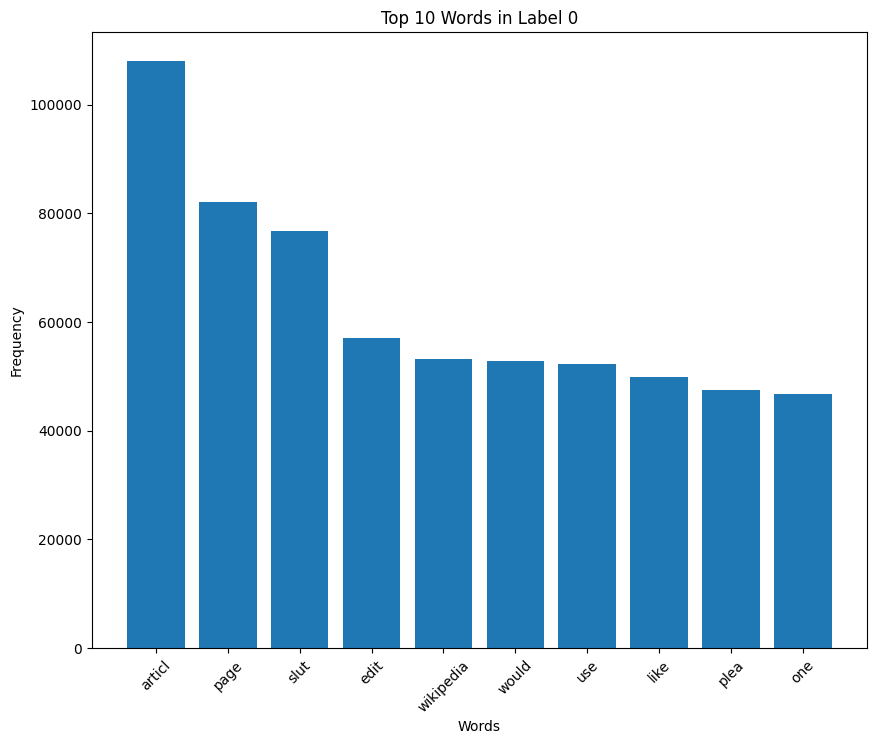

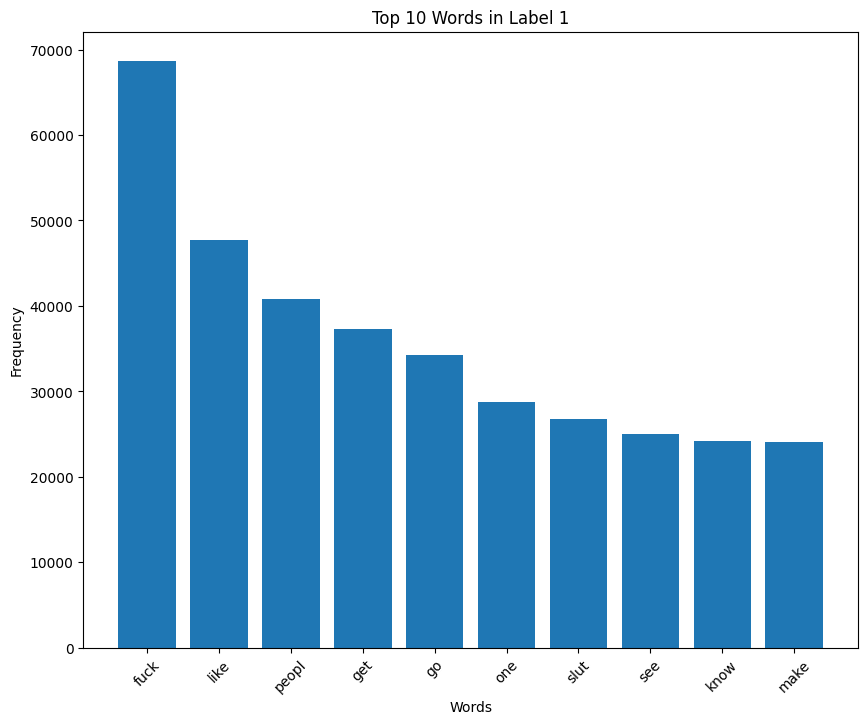

In [5]:
import matplotlib.pyplot as plt

for label, counter in word_counts_by_label.items():
    # Choose the 10 most common words
    top_words = counter.most_common(10)
    words = [word[0] for word in top_words]
    frequencies = [word[1] for word in top_words]
    
    plt.figure(figsize=(10, 8))
    plt.bar(words, frequencies)
    plt.title(f'Top 10 Words in Label {label}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

**Analysis：**

From the figure, we are surprised by the high frequency of the word 'slut' appearing in remarks marked as harmless. Other high-frequency words are relatively neutral. In addition, 'slut' also shows in malicious comments with high frequency.

# Tokenize the text

Here we're going to try 3 different ways to tokenize the text
- TF-IDF
- Word2Vec
- FasrWord

In [18]:

!pip install scikit-learn
!pip install gensim

### Remove outliers

We first calculated the length of each text and visualized it using box plots. And we use the concept of outliers to remove outliers

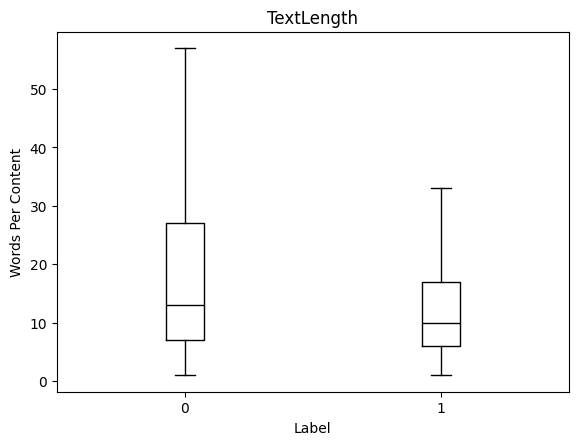

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Calculate text length

df['TextLength'] = df['Content'].str.split().apply(len)

import matplotlib.pyplot as plt

# Count the number of words in each text
df['WordsPerContent'] = df['Content'].str.split().apply(len)

# Generate boxplots by labels without showing outliers
df.boxplot(
    "TextLength", by="Label", grid=False, showfliers=False, color="black"
)
plt.suptitle("")  # remove subtitle
plt.xlabel("Label")
plt.ylabel("Words Per Content")
plt.show()

In [3]:
import pandas as pd
import numpy as np

df=pd.read_csv('processed.csv')  

df.head()

,Content,Label,Words Per Tweet,TextLength,WordsPerContent
0,denial normal con ask comment tragedi emot retard,1,8,8,8
1,abl tweet insuff bullshit prove trump nazi vagina,1,8,8,8
2,retard cute singl life,1,4,4,4
3,thought real badass mongol style declar war at...,1,11,11,11
4,afro american basho,1,3,3,3


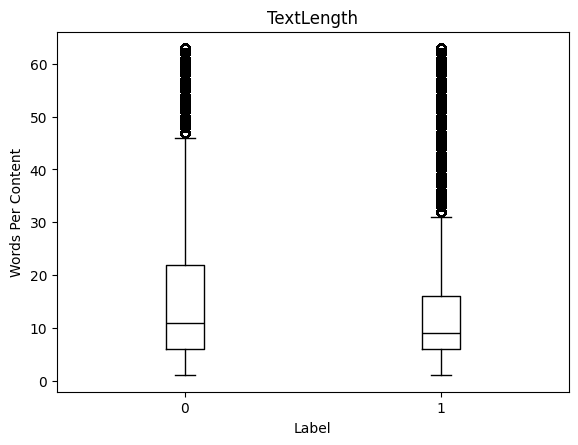

In [6]:
# With outliers

import pandas as pd
import matplotlib.pyplot as plt
df.boxplot(
    "TextLength", by="Label", grid=False, showfliers=True, color="black"
)
plt.suptitle("")  
plt.xlabel("Label")
plt.ylabel("Words Per Content")
plt.show()

With the definition of outliers: a data point is an outlier if it is more than 1.5 ⋅ IQR ‍ above the third quartile or below the first quartile, we can count outliers.
* lower_bound = Q1 - 1.5 * IQR
* upper_bound = Q3 + 1.5 * IQR

In [7]:
# Calculate quartiles for each label group
Q1 = df.groupby('Label')['Content'].apply(lambda x: x.str.split().str.len().quantile(0.25))
Q3 = df.groupby('Label')['Content'].apply(lambda x: x.str.split().str.len().quantile(0.75))

# Caculate IQR
IQR = Q3 - Q1

# Define the range of outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove outliers
filtered_df = df[~((df['Content'].str.split().str.len() < (df['Label'].map(lower_bound))) | 
                   (df['Content'].str.split().str.len() > (df['Label'].map(upper_bound))))]

filtered_df.head()

,Content,Label,Words Per Tweet,TextLength,WordsPerContent
0,denial normal con ask comment tragedi emot retard,1,8,8,8
1,abl tweet insuff bullshit prove trump nazi vagina,1,8,8,8
2,retard cute singl life,1,4,4,4
3,thought real badass mongol style declar war at...,1,11,11,11
4,afro american basho,1,3,3,3


Draw a box plot after removing outliers

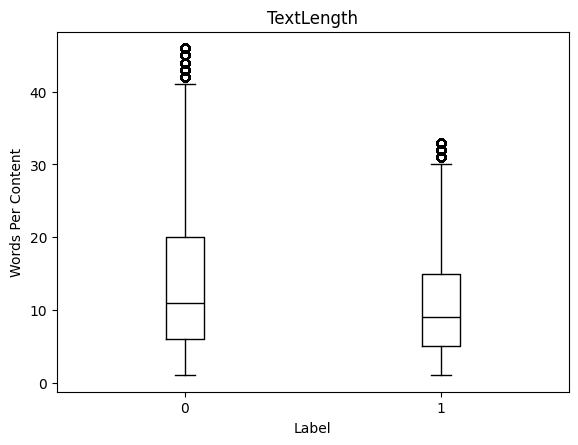

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_df.boxplot(
    "TextLength", by="Label", grid=False, showfliers=True, color="black"
)
plt.suptitle("")  
plt.xlabel("Label")
plt.ylabel("Words Per Content")
plt.show()

We can still see some outliers from the picture, but they are relatively acceptable. 

# Balance the dataset

And we check the number of samples in each label again.

In [9]:
Label_counts = filtered_df['Label'].value_counts()
print(Label_counts)

Label
1    334524
0    314205
Name: count, dtype: int64


In order not to affect the performance of the model, prevent the model from being biased towards the majority class, improve the recognition ability of the minority class and improve the generalization ability of the model, we rebalanced the data by deleting samples in label 1.

In [12]:
from sklearn.utils import resample

# Get samples for each category separately
df_majority = filtered_df[filtered_df.Label==1]
df_minority = filtered_df[filtered_df.Label==0]

# Reduce the number of samples from the majority class to the same number as the minority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,      # No replacement means there will be no duplicate samples
                                   n_samples=len(df_minority), # The number of samples matching the minority class
                                   random_state=123)    # Random seeds ensure reproducible results

# Merge the reduced majority class samples with the minority class samples
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Print category counts again to confirm balance
label_counts_balanced = df_balanced['Label'].value_counts()
print(label_counts_balanced)


Label
1    314205
0    314205
Name: count, dtype: int64


In [13]:
df.to_csv('processed.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("processed.csv") #Load the dataset to avoid running from scratch

df 

X=df['Content'].fillna('', inplace=True)

y=df['Label']

/tmp/ipykernel_2737/1649638978.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X=df['Content'].fillna('', inplace=True)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# TF-IDF

Term Frequency - Inverse Document Frequency (TF-IDF) is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus).

- Term Frequency: TF of a term or word is the number of times the term appears in a document compared to the total number of words in the document.

  $TF = \frac{number\,of\, times\, the\, tern\, appears\, in\, the\, document}{total\, number\, of\, terms\, in\, the\, document}$

- Inverse Document Frequency: IDF of a term reflects the proportion of documents in the corpus that contain the term. Words unique to a small percentage of documents (e.g., technical jargon terms) receive higher importance values than words common across all documents (e.g., a, the, and).
  
  $IDF = log\left(\frac{numbers\, of\, the\, documents\, in\, the\, corpus}{number\, of\, documents\, in\, the\, corpus\, contain\, the\, term}\right)$

- The TF-IDF of a term is calculated by multiplying TF and IDF scores.
  
  $TF-IDF=TF*IDF$


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

# Replace NaN values with an empty string or any other appropriate strategy
df['Content'].fillna('', inplace=True)

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit-transform the data
X_tfidf = tfidf_vectorizer.fit_transform(df['Content'])

In [5]:
print(X_tfidf.shape)

(688057, 90111)


### Prediction
Split the datasets into training(80%) and testing(20%) sets. And we use a simple model--Logistic Regression classifier to test.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Instantiate the Logistic Regression classifier
logreg_classifier = LogisticRegression(max_iter=1000, solver='saga')  # Increase max_iter and change solver

# Train the Logistic Regression classifier with progress bar
progress_bar = tqdm(total=100)
logreg_classifier.fit(X_train, y_train)
progress_bar.update(100)
progress_bar.close()

# Predict on the testing set
y_pred = logreg_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]

Accuracy: 0.8301746940673779


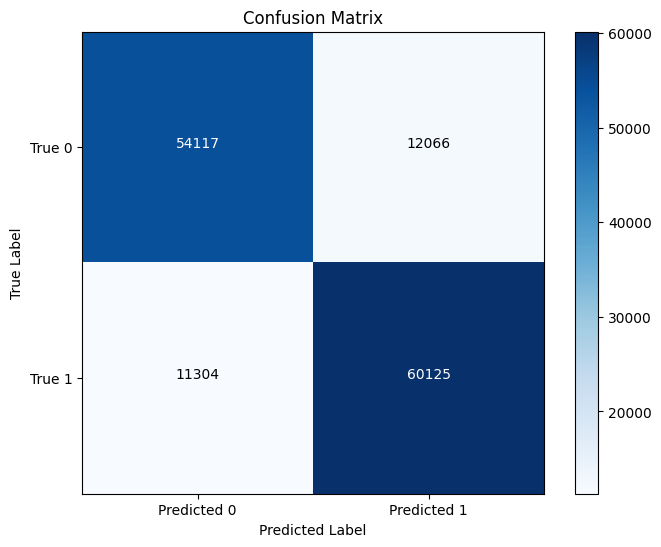

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
# Plot Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'), horizontalalignment="center", color="white" if conf_mat[i, j] > conf_mat.max() / 2 else "black")
plt.show()

**Analysis:** 

From the confusion matrix, we can calculate the accuracy: (54117+60125) / (12066+11304+54117+60125) = 83.017%

# Word2Vec

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.

We set the dimension of the vector trained by the model to 100 dimensions. Windows size is set to 5, that is, when the model learns the representation of each word, it will consider the contextual information within 5 words before and after the target word. We also stipulate that only words that appear at least 2 times in the entire data set will be considered for model training. This helps remove rare words, reduce model noise, and reduce computational resource requirements. In addition, to speed up model training, we use 4 worker threads to train the model in parallel, which can speed up the model training process, especially when processing large data sets.


In [13]:
#word2vec
!pip install gensim

from gensim.models import Word2Vec

#y=df['sentiment']

# Tokenize the cleaned reviews
tokenized_reviews = [review.split() for review in df['Content']]

# Train the Word2Vec model
w2v_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

Defaulting to user installation because normal site-packages is not writeable


# Visualize some word vectors


We visualize the relationship between these word vectors on a two-dimensional interface. The smaller the cos value between the two vectors, the closer the relationship between the two words.

Since the dimensions of vector is 100, we use t-SNE to reduce the order to 2 dimensions.

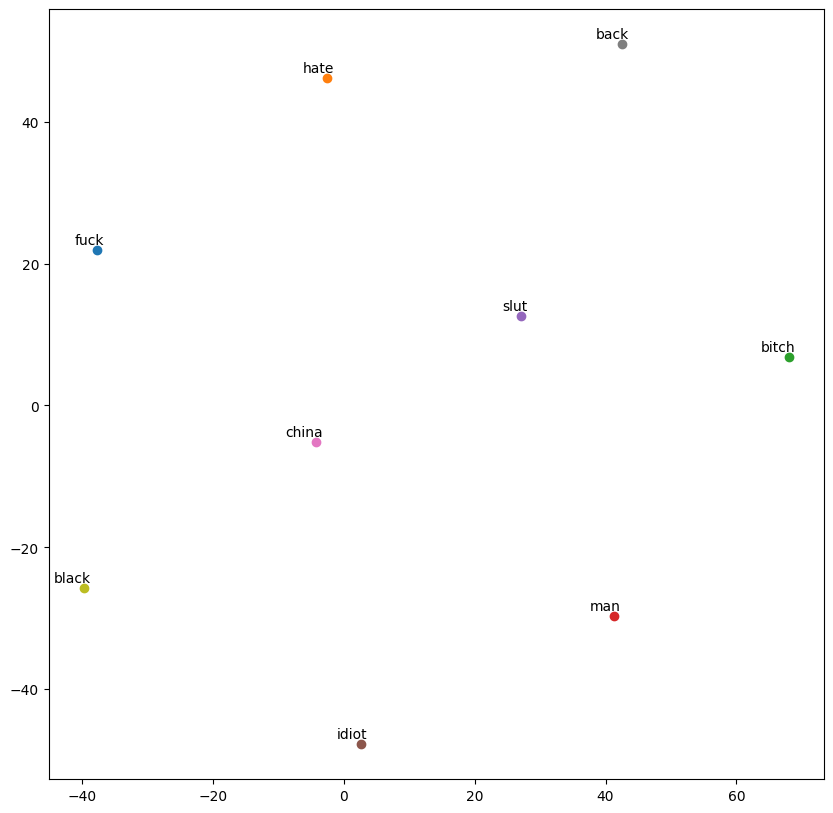

In [19]:
# Updated code to resolve IndexError issues
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Choose some words to visualize
words = ['fuck', 'hate', 'bitch', 'asshole', 'man', 'slut', 'idiot', 'apple', 'china','back','black']

# Get the word vectors for these words and make sure the words exist in the model
# Create a list of words that exist in the model
valid_words = [word for word in words if word in w2v_model.wv]
word_vectors = np.array([w2v_model.wv[word] for word in valid_words])

# Use t-SNE to reduce the dimension
tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(valid_words)-1))
word_vectors_2d = tsne.fit_transform(word_vectors)

# Visualize
plt.figure(figsize=(10, 10))
for i, word in enumerate(valid_words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

In [18]:
# Save the model
model_path = "word2vec_model.bin"
w2v_model.save(model_path)

### Prediction

Split the datasets into training(80%) and testing(20%) sets.

After word2vec, we firstly use PCA to reduce the dimensions, then use SVM classifier to predict and evaluate.

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Generate document feature vectors
def document_vector(word2vec_model, doc):
    # Delete words that are not in the vocabulary
    doc = [word for word in doc if word in word2vec_model.wv]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the average of word vectors
    return np.mean(word2vec_model.wv[doc], axis=0)

# Compute vectors for each document
doc_vectors = np.array([document_vector(w2v_model, doc) for doc in tokenized_reviews])

# Appy PCA to reduce the orders
pca = PCA(n_components=50)  # n_components 可以根据需要调整
doc_vectors_pca = pca.fit_transform(doc_vectors)

# Split the datasets
X_train, X_test, y_train, y_test = train_test_split(doc_vectors_pca, df['Content'], test_size=0.2, random_state=42)

# Train SVM classifier
svm = SVC(kernel='linear')  # kernel can change due to our needs
svm.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      4961
    positive       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



**Analysis:** 

The accuracy of prediction is 85%.

*Why we choose the mean value of word vector?*

* Dimensionality consistency: By averaging word vectors, you get a fixed-size vector regardless of the length of the original text. This is necessary for input into traditional machine learning models.
* Preserve semantic information: Each word vector generated by the Word2Vec model captures the semantic information of the word. By averaging the vectors of all words in a document, a semantic representation of the entire document can be synthesized to a certain extent.
* Simple and effective: Although this method is simple, it is surprisingly effective in many situations. It does not require complex operations and is relatively cheap to compute, while often providing sufficiently good results, especially on large-scale data sets.
  

# FastText

FastText is a word vector representation and text classification tool developed by the Facebook AI Research (FAIR) team. FastText is similar to Word2Vec, but has some key differences:

* Subword information: One of the main innovations of FastText is that it takes into account the internal structure of words. It not only learns vector representations of words, but also learns vector representations of individual substrings (n-grams) of words. For example, for the word "apple", it considers the substrings "ap", "app", "appl", "apple" and "pp", "ppl", "pple". This makes FastText particularly suitable for handling spelling errors and inflections (e.g. plural forms, tense changes, etc.).
* Handling unknown words: Because FastText takes subword information into account, it can generate vectors for words outside the training vocabulary. This is a significant advantage over Word2Vec, which cannot directly generate vectors for words that do not appear in the training set.
* Application areas: Although FastText is often used to generate word vectors, it is also often used for text classification tasks, providing efficient training and classification methods, especially for large-scale data sets.
* Performance: FastText often provides performance that is comparable to or better than Word2Vec across a variety of languages ​​and tasks, especially when dealing with syntactically rich or morphologically complex languages.
* FastText is a powerful and flexible tool suitable for a variety of natural language processing tasks. Because of its processing of subword information, it is particularly suitable for applications that need to be sensitive to morphological changes or spelling errors.


In [ ]:
# add a gride search to find the best parameter

In [1]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.model_selection import train_test_split


df = pd.read_csv("processed.csv")


df_sampled = df.groupby('Label').apply(lambda x: x.head(10000)).reset_index(drop=True)


df_sampled['fasttext_format'] = '__label__' + df_sampled['Label'].astype(str) + ' ' + df_sampled['Content']


train_df, validate_df = train_test_split(df_sampled, test_size=0.2, random_state=42)


train_df['fasttext_format'].to_csv("fasttext_train.txt", index=False, header=False)
validate_df['fasttext_format'].to_csv("fasttext_validate.txt", index=False, header=False)

/tmp/ipykernel_7994/1144591639.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('Label').apply(lambda x: x.head(10000)).reset_index(drop=True)


In [2]:
def train_and_evaluate(parameter_grid, train_file, validate_file):
    best_model = None
    best_accuracy = 0
    best_params = {}
    
    for lr in parameter_grid['lr']:
        for epoch in parameter_grid['epoch']:
            for wordNgrams in parameter_grid['wordNgrams']:
                model = fasttext.train_supervised(input=train_file,
                                                  lr=lr,
                                                  epoch=epoch,
                                                  wordNgrams=wordNgrams)
                result = model.test(validate_file)
                accuracy = result[1]
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model
                    best_params = {'lr': lr, 'epoch': epoch, 'wordNgrams': wordNgrams}
    
    return best_model, best_accuracy, best_params


parameter_grid = {
    'lr': [0.1, 0.5, 1.0],
    'epoch': [5, 10, 20],
    'wordNgrams': [1, 2, 3]
}


best_model, best_accuracy, best_params = train_and_evaluate(parameter_grid, "fasttext_train.txt", "fasttext_validate.txt")

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")


Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:  390102 lr:  0.000000 avg.loss:  0.357022 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:  217409 lr:  0.000000 avg.loss:  0.302651 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:   50157 lr:  0.000000 avg.loss:  0.345238 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:  379854 lr:  0.000000 avg.loss:  0.300722 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:  173774 lr:  0.000000 avg.loss:  0.154735 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:   82485 lr:  0.000000 avg.loss:  0.169313 ETA:   0h 0m 0s
Read 0M words
Number of words:  11755
Number of labels: 2
Progress: 100.0% words/sec/thread:  

Best Accuracy: 0.8335002503755633
Best Parameters: {'lr': 0.1, 'epoch': 10, 'wordNgrams': 2}
